# Inventory Control under Non-Stationary Demand
Optimal inventory control is an active field of research in management science and a classic problem of stochastic optimization. The problem extends the newsvendor model as it allows to store unsold items for sale in a subsequent selling period.

## The Optimization Problem
|Symbol|Description|
|---|---|
|$t$|time index|
|$s_t$|sell|
|$b_t$|buy|
|$i_t$|inventory with $i_0$ fixed|
|$d_t$|random demand|
|$D_t$|demand history up to $t$|

The decision-maker seeks to find an optimal policy that maximizes the expected rewards from buying and selling a product under uncertain demand. It is assumed that demand must be fulfilled with inventory that is on stock at the beginning of a period and that left-over inventores can be stored. A mathematical model that describes this decision problem as a so-called multistage stochastic optimization problem would look as follows:
$$\begin{align}
\max \ & \sum_{t=1}^T \mathbb{E}\left[ p s_t(D_t) - c b_t(D_t) - h i_t(D_t)\right]& \\
s.t. \  & i_t(D_t) = i_{t-1}(D_t) - s_t(D_t) + b_t(D_t)& t=1,...,T \\
& s_t(D_t) \leq i_{t-1}(D_t)& t=1,...,T \\
& s_t(D_t) \leq d_t& t=1,...,T. 
\end{align}$$

We now use QUASAR stochastic optimizer to model, solve, and analyze this optimization problem. The optimizer can be accessed through a Python library which must be imported first.

In [1]:
from pyquasar import *

### The Decision Problem
First, we must first define a couple of parameters 

In [2]:
num_months = 12
initial_inventory = 12
sales_price = 5
inventory_cost = 0.5
buying_price = 2
max_inventory = 1000

Because we make the same type of decisions in each period, we add the same variables and equations during each loop. At the end of a loop, we change the reference of <code>begin_inventory</code> to <code>end_inventory</code>. Python is very flexible with the type of the variable <code>begin_inventory</code> which was an <code>int</code> during the first loop and became a <code>DecisionVariable</code> afterwards.

In [3]:
model = DecisionProblem()
begin_inventory = initial_inventory
for t in range(num_months):
    
    # decision variables
    buy, sell, end_inventory = model.add_variables(t, "buy", "sell", "inventory")
    
    # bounds
    model += sell <= rand("demand")
    model += sell <= begin_inventory
    model += end_inventory <= max_inventory

    # inventory balance
    model += end_inventory == begin_inventory - sell + buy

    # objective function / immediate reward
    model += sales_price*sell - inventory_cost*end_inventory - buying_price*buy
    
    # state transition
    begin_inventory = end_inventory

####Remark
Since inventory is a time-coupling variable, it is recommended to add a very loose upper bound for this variable so that the model fulfills the relatively complete recourse assumption. This may seem rather theoretical, but it often happens that the solution algorithm is  if the equivalent dynamic programming formulation becomes unbounded.

### The Stochastic Demand Process
Often, we do not know where our sales are going, except they they are somewhat tied to some macroeconomic factors that are hard to predict and can eventually end up trending in any direction.

Instead of putting too many assumptions into our demand model, let's just say that there is a relative relationship between the currently observed demand and next period's demand. This ensures that demand is positive and demand shocks increase with the current demand level. If we assume that the log-ratio of these shocks follows a normal distribution and that there is no drift, we arrive at the geometric Brownian motion as our stochastic demand model. The GBM demand process is defined as
$$d_t = \exp \left( \log(d_t) + \varepsilon \right), \ \varepsilon \sim N(0,\sigma).$$

To define the demand process, we have to define the initial state of the demand process, namely the demand of this months, as well as the standard deviation of the log-normal ditribution which defines the distribution of percentage change from one period to the next.

In [4]:
name ="demand"
drift = 0
sigma = 0.2
initial_demand = 10

In QUASAR, we can create a GBM process quite easily by using the <code>GBM</code> class. Once the object has been created, a simulation sample can be drawn, analyzed, and visualized in various ways.

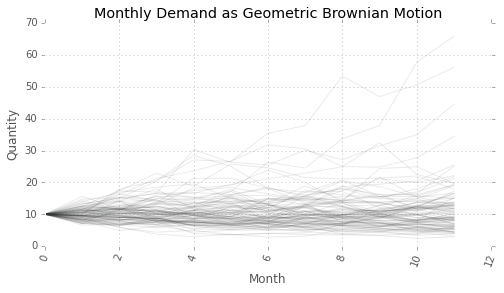

In [5]:
gbm_demand = GBM(name, volatility=sigma, drift = 0, initial_state=initial_demand)
sample = gbm_demand.simulate(num_stages=num_months, sample_size=100)
sample.demand.spaghetti(title='Monthly Demand as Geometric Brownian Motion', ylabel='Quantity', xlabel='Month')

## Solution Method
To solve the stochastic decision problem to optimality we will use QUASAR's dynamic optimizer. The dynamic optimizer automatically computes an approximation of the optimal decision policy. Internally, it approximates the stochastic process by using a small set of discrete price states called nodes. The quality of the approximation largely depends on how many of these nodes there are and how they are being selected. The optimizer handles these steps automatically. However, it is always a good idea to manually adjust the number of nodes to see if the quality of the approximation is changing. In most cases, the default setting will be sufficient.

The optimizer is started by calling

In [6]:
opt = DynamicOptimizer(model, gbm_demand, num_nodes=50)
opt.solve()
opt.join()

Once the optimizer has converged, we can gather some information about the solution process. Solution statistics are stored in a Pandas DataFrame which can be accessed through the attribute <code>DynamicOptimizer.stats</code>.

In [7]:
opt.stats.tail()

,expReward,simReward,stdError,hyperplanes,numSolves,duration
iter,,,,,,
118,340.66,353.33,34.15,14924,65135,3
119,340.65,358.60,34.78,15120,65687,3
120,340.62,361.17,34.67,15239,66239,3
121,340.59,372.75,33.33,15424,66791,3
122,340.56,335.97,8.12,15597,67343,3


## Solution Output Analysis

Once the optimizer is finished, we can obtain the solution which takes the form of a policy, <code>opt.policy</code>. This policy can be simulated, much like the stochastic process has been simulated.

In [8]:
solution = opt.policy.simulate(sample_size=1000)

We can take a look at the total profit distribution by grouping the immediate rewards at each stage by their series and the forming the sum over a single series.

In [9]:
solution.rewards.groupby_series.sum().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rewards,1000.00,335.61,110.93,165.68,250.50,314.13,400.72,769.09


The <code> solution </code> holds all simulated sample paths of the optimal policy as a Pandas DataFrame, containing the values of each decision variable as well as the realizations of the random variable, but also the reward at each stage and the shadow prices of the time-coupling variables which can be used for some advanced decision analyses. 

Much like with the demand process, the time series of the decision variables or immediate reward can also be visualized. We can also take a look at a histogram of the total rewards distribution. Or generate a spaghetti plot of the discretized demand process.

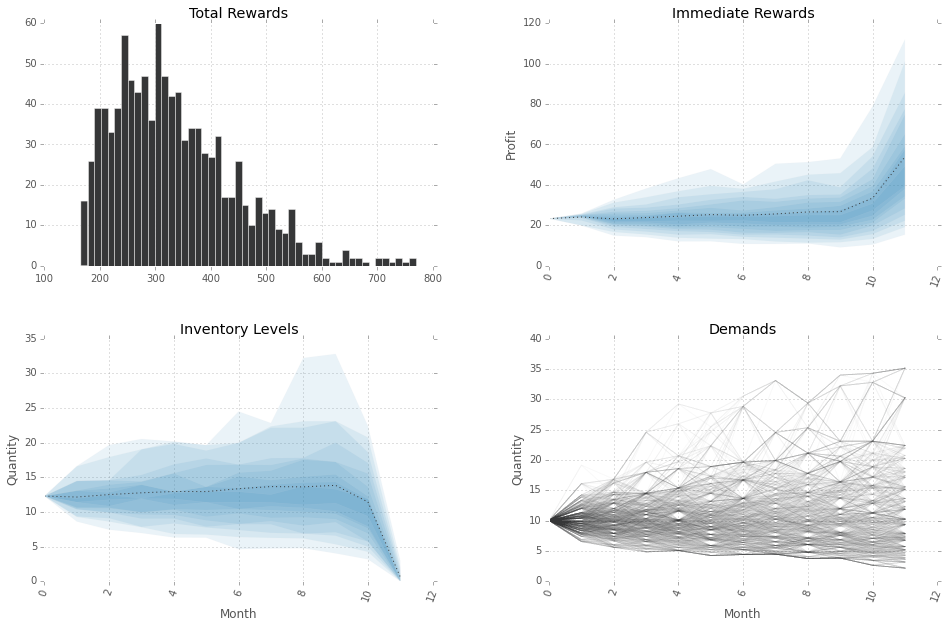

In [10]:
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(16,10))
solution.rewards.groupby_series.sum().hist(ax=ax1, bins=50)
ax1.set_title('Total Rewards')
solution.rewards.fanchart(title='Immediate Rewards', ylabel='Profit', xlabel='', ax=ax2)
solution.decision.inventory.fanchart(title='Inventory Levels', ylabel='Quantity', xlabel='Month', ax=ax3)
solution.state.demand.spaghetti(title='Demands', ylabel='Quantity', xlabel='Month', alpha=.03, ax=ax4)

## Deriving Simple Rules
With the demand process being GBM and no fixed order cost given, we can condlude that the optimal control rule of an infinite horizon problem must be of type *(s,s-1)*, whereby *s* depends on the state, which in this case is demand.

Let us take a look at the relationship of demand and inventory level at the end of each stage. Since the decision problem has got a finite horizon, there will be boundary effects, which may lead to biased results.

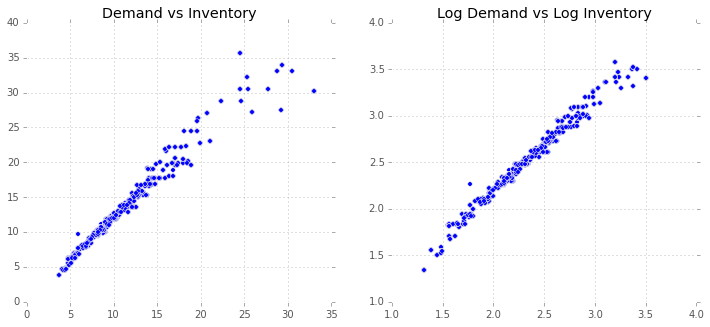

In [11]:
unbiased_solution = solution.query('stage > 2 & stage < 9')
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.scatter(x=unbiased_solution.state.demand, y=unbiased_solution.decision.inventory)
ax1.set_title('Demand vs Inventory')
ax2.scatter(x=np.log(unbiased_solution.state.demand), y=np.log(unbiased_solution.decision.inventory))
ax2.set_title('Log Demand vs Log Inventory')
plt.show()

From the visual inspection, there appears to be an approximately linear relationship. Let us exploit this insight to derive an inventory control where *s* is a linear function of demand which would provide us with a state-dependent *(s,s-1)* rule.

### Linear Regression

The way we can achieve this is by running a linear regression on the inventory levels with demand as explanatory variable. The regression model would be $s = \beta d + \varepsilon$ (without a constant).

In [12]:
import statsmodels.api as sm
X = unbiased_solution.state.demand
y = unbiased_solution.decision.inventory
reg = sm.OLS(y,X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inventory   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.144e+06
Date:                Wed, 01 Jul 2015   Prob (F-statistic):               0.00
Time:                        09:50:47   Log-Likelihood:                -8786.5
No. Observations:                6000   AIC:                         1.757e+04
Df Residuals:                    5999   BIC:                         1.758e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
demand         1.2028      0.001   1069.658      0.000         1.201     1.205
==============================================================================
Omnibus:                     2761.951   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           158956.109
Skew:                          -1.407   Prob(JB):                         0.00
Kurtosis:                      28.058   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The *(s,s-1)* rule that could be derived from this would be $s = \beta d$.

In [13]:
beta = reg.params['demand']
'basestock = %f*demand'%beta

'basestock = 1.202778*demand'

### Policy Comparison
Now let's compare the performance of the linear decision rule with the optimal policy. For this, we are going to cut off the demand states of the last three stages to avoid end-of-horizon effects. We can then grab the coefficient from the regression model and implement a short simulation of the sequential decision process under the linear decision rule.

In [14]:
groups = solution.query('stage < 9').state.demand.groupby_series
rewards = []
for i in range(groups.ngroups):
    inventory = initial_inventory
    reward = 0.
    for demand in groups.get_group(i).values:
        sell = min(demand,inventory)
        buy = max(0,beta*demand - (inventory-sell))
        reward += sales_price*sell - buying_price*buy - inventory_cost*inventory
        inventory = inventory + buy - sell
    rewards.append(reward)

Then, we can compare the total reward distribution of the linear decision rule with the total reward distribution for the same stages under the optimal policy.

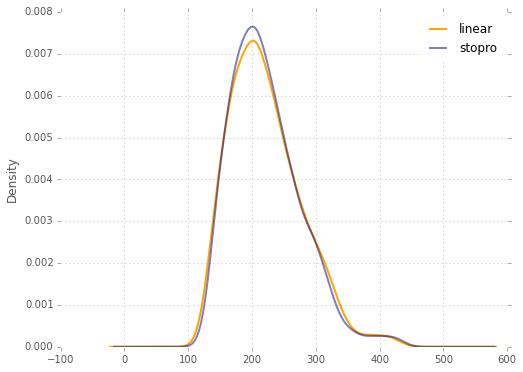

In [15]:
rewards1 = pd.DataFrame(rewards, columns=['linear'])
rewards2 = pd.DataFrame(solution.query('stage < 9').rewards.groupby_series.sum().values, columns=['stopro'])
f, ax = plt.subplots(1,1,figsize=(8,6))
rewards1.plot(kind='kde', ax=ax, color='orange', linewidth=2)
rewards2.plot(kind='kde', ax=ax, color='darkblue', linewidth=2, alpha=0.5)
plt.show()

The comparison shows that the expected total rewards under each policy are not significantly different. This means that the simple linear policy provides a near-optimal rule of thumb that could be used by a practitioner.